In [1]:
import numpy as np
import theano
import theano.tensor as T
from theano.tensor.signal import downsample
from theano.tensor.nnet import conv2d
from scipy import misc
from matplotlib.pyplot import imshow
%matplotlib inline

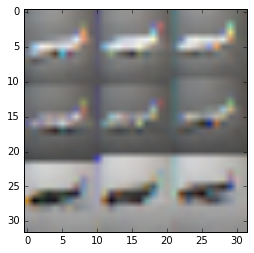

In [7]:
import cPickle
img = 0
with open("CIFAR10_dataset/data_batch_1") as f:
    img = cPickle.load(f)["data"][457].reshape(32,32,3) # 32x32 image input

#misc.imshow(img)
imshow(img)
def LReLU(narr):
    return theano.tensor.switch(narr<0, 0.01*narr, narr)
def PReLU(narr, p = 0.001):
    return theano.tensor.switch(narr<0, p*narr, narr)

[ 1 16 13 13]
[ 1 16  7  7]


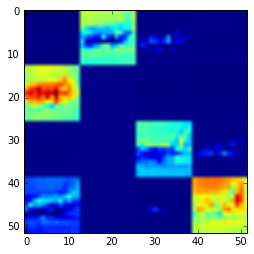

In [8]:
#assert img.shape[0] == img.shape[1], "Shape not is correct"
rng = np.random.RandomState(23455) # random class init.
batch_size = 1 #initially single image so...
l0_img = np.asarray(img.reshape(batch_size,img.shape[2],img.shape[0],img.shape[1]), dtype=theano.config.floatX)

# layer1 with max pool.

fil_no1 = 16
img_shape1 = l0_img.shape
filt_shape1 = (fil_no1, 3, 7, 7)
poolsize1 = (2,2)

# initialization of filter and bias is taken from LeNet implementation. (Yet to be changed to others)
i = np.prod(filt_shape1[1:])
o = (filt_shape1[0] * np.prod(filt_shape1[2:]) //
                   np.prod(poolsize1))
f_bound = np.sqrt(6. / (i + o)) # interval bound for scaled uniform distributed filter
init_filt = theano.shared(np.asarray(rng.uniform(low=-f_bound, high=f_bound, size=filt_shape1),
                                        dtype=theano.config.floatX),borrow=True) # uniform distribution in randomness
bias = theano.shared(value=np.zeros((filt_shape1[0],), dtype=theano.config.floatX), borrow=True)

tmp = conv2d(input=l0_img, filters=init_filt, image_shape=img_shape1, filter_shape=filt_shape1, subsample=poolsize1)
l1_out = LReLU(tmp)
#first pooling and then LReLU.
pool1_out = downsample.max_pool_2d(input = l1_out, ds =poolsize1, ignore_border=False)

# for backprop: save input, filters and bias

print l1_out.shape.eval()
print pool1_out.shape.eval()
#misc.imshow(l1_out.eval()[0][0])
#im = l1_out.eval()[0]
s = np.zeros((l1_out.shape.eval()[2]*4,l1_out.shape.eval()[2]*4))
j = 0
k = 0
for i in range(l1_out.shape.eval()[1]):
    s[j:l1_out.shape.eval()[2]+j,k:l1_out.shape.eval()[2]+k] += l1_out.eval()[0][i]
    if j == 39 and k == 39:
        break
    if (i%4 < 4 and i%4 > 0) or (i == 0):
        j += l1_out.shape.eval()[2]
    if i%4 == 0 and i!=0:
        j = 0
        k += l1_out.shape.eval()[2]
    if j ==52:
        j = 0
        k += l1_out.shape.eval()[2]
#misc.imshow(s)
imshow(s)

In [23]:
# layer 2.

fil_no2 = 32
sh = pool1_out.shape.eval()
img_shape2 = (batch_size, fil_no1,sh[2], sh[3])
filt_shape2 = (fil_no2, fil_no1, 3, 3)
poolsize2 = (1,1)

i = np.prod(filt_shape2[1:])
o = (filt_shape2[0] * np.prod(filt_shape2[2:]) //
                   np.prod(poolsize2))
f_bound = np.sqrt(6. / (i + o)) # interval bound for scaled uniform distributed filter
init_filt = theano.shared(np.asarray(rng.uniform(low=-f_bound, high=f_bound, size=filt_shape2),
                                        dtype=theano.config.floatX),borrow=True) # uniform distribution in randomness
bias = theano.shared(value=np.zeros((filt_shape2[0],), dtype=theano.config.floatX), borrow=True)

l2_out = LReLU(conv2d(input=pool1_out, filters=init_filt, image_shape=img_shape2, filter_shape=filt_shape2, subsample=poolsize2))

print l2_out.shape.eval()
s = np.zeros((l2_out.shape.eval()[2],l2_out.shape.eval()[2]))
for i in l2_out.eval()[0]:
    s += i
misc.imshow(s)

[ 1 32  5  5]


In [25]:
# layer 3.

fil_no3 = 64
sh = l2_out.shape.eval()
img_shape3 = (batch_size, fil_no2,sh[2], sh[3])
filt_shape3 = (fil_no3, fil_no2, 3, 3)
poolsize3 = (1,1)

i = np.prod(filt_shape3[1:])
o = (filt_shape3[0] * np.prod(filt_shape3[2:]) //
                   np.prod(poolsize3))
f_bound = np.sqrt(6. / (i + o)) # interval bound for scaled uniform distributed filter
init_filt = theano.shared(np.asarray(rng.uniform(low=-f_bound, high=f_bound, size=filt_shape3),
                                        dtype=theano.config.floatX),borrow=True) # uniform distribution in randomness
bias = theano.shared(value=np.zeros((filt_shape3[0],), dtype=theano.config.floatX), borrow=True)

l3_out = LReLU(conv2d(input=l2_out, filters=init_filt, image_shape=img_shape3, filter_shape=filt_shape3, subsample=poolsize3))

print l3_out.shape.eval()
s = np.zeros((l3_out.shape.eval()[2],l3_out.shape.eval()[2]))
for i in l3_out.eval()[0]:
    s += i
misc.imshow(s)

[ 1 64  3  3]


In [27]:
# layer 4.

fil_no4 = 128
sh = l3_out.shape.eval()
img_shape4 = (batch_size, fil_no3,sh[2], sh[3])
filt_shape4 = (fil_no4, fil_no3, 3, 3)
poolsize4 = (1,1)

i = np.prod(filt_shape4[1:])
o = (filt_shape4[0] * np.prod(filt_shape4[2:]) //
                   np.prod(poolsize4))
f_bound = np.sqrt(6. / (i + o)) # interval bound for scaled uniform distributed filter
init_filt = theano.shared(np.asarray(rng.uniform(low=-f_bound, high=f_bound, size=filt_shape4),
                                        dtype=theano.config.floatX),borrow=True) # uniform distribution in randomness
bias = theano.shared(value=np.zeros((filt_shape4[0],), dtype=theano.config.floatX), borrow=True)

l4_out = LReLU(conv2d(input=l3_out, filters=init_filt, image_shape=img_shape4, filter_shape=filt_shape4, subsample=poolsize4))

print l4_out.shape.eval()
s = np.zeros((l4_out.shape.eval()[2],l4_out.shape.eval()[2]))
for i in l4_out.eval()[0]:
    s += i
misc.imshow(s)

[  1 128   1   1]


In [26]:
# Fully Connected layer.
n_in = l4_out.shape.eval()[2]*l4_out.shape.eval()[3]
n_out = l4_out.shape.eval()[1]
W_val = np.asarray(rng.uniform(
                    low=-np.sqrt(6. / (n_in + n_out)),
                    high=np.sqrt(6. / (n_in + n_out)),
                    size=(n_in, n_out)
                ),
                dtype=theano.config.floatX
            )
W = theano.shared(value=W_val, name='W', borrow=True)
b_val = np.zeros((n_out,), dtype=theano.config.floatX)
b = theano.shared(value=b_val, name='b', borrow=True)
f_out = T.dot(l4_out, W) + b
F_output = T.tanh(f_out)

print F_output.eval()

[[[[-0.06504142  0.09976152 -0.11006453 ..., -0.03041761  0.02469872
    -0.0379149 ]]

  [[ 0.99986801 -0.99999925  0.99999984 ...,  0.97795451 -0.94937845
     0.99267552]]

  [[ 0.99921059 -0.99998824  0.99999664 ...,  0.94987686 -0.90262358
     0.97937815]]

  ..., 
  [[ 0.93539048 -0.98929189  0.99376933 ...,  0.66071645 -0.56810378
     0.75735297]]

  [[-0.05067665  0.07778725 -0.08584533 ..., -0.02368942  0.01923472
    -0.02953034]]

  [[-0.01309383  0.02012053 -0.02221401 ..., -0.00611704  0.00496646
    -0.00762602]]]]


# define forward expression
relu = T.maximum(x, 0.)
 
# define backward expression
out = T.matrix('out')
grelu = theano.grad(None, x, known_grads={relu: out})
# compile backward expression
fgrelu = theano.function([x, out], grelu)
# optional: print graph
from theano.printing import debugprint
print "Original graph:"
debugprint(grelu)
print "\nOptimized graph:"
debugprint(fgrelu)

References:

@article{He2015,
    author = {Kaiming He and Xiangyu Zhang and Shaoqing Ren and Jian Sun},
    title = {Deep Residual Learning for Image Recognition},
    journal = {arXiv preprint arXiv:1512.03385},
    year = {2015}
}


Inspirations:

Lecture 8, CS231n course, Stanford University.
Machine Learning, Andrew Ng, Coursera.

https://github.com/KaimingHe/deep-residual-networks

http://www.deeplearning.net/tutorial/lenet.html

http://deeplearning.net/tutorial/code/convolutional_mlp.py

https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network3.py

http://ethereon.github.io/netscope/#/gist/d38f3e6091952b45198b

https://github.com/ppwwyyxx/tensorpack/blob/master/examples/ResNet/cifar10-resnet.py

https://github.com/Lasagne/Recipes/blob/master/papers/deep_residual_learning/Deep_Residual_Learning_CIFAR-10.py


For tensorflow:

https://github.com/aymericdamien/TensorFlow-Examples
